In [1]:
!pip install scikit-learn

In [2]:
import gurobipy as gp
from gurobipy import GRB
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader  # Corrected import
from torch_geometric.nn import MessagePassing
from torch_geometric.nn import global_mean_pool  # For pooling in the decoder
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import random
import matplotlib.pyplot as plt  # For plotting losses

In [3]:
from parse_QP import my_callback, parse_qplib_file

In [4]:
# Read the problem
number = "0031"
grb_model = gp.read(f"QPLIB_{number}.lp")

# Solution storage
grb_model._feasible_solutions = []
grb_model._relaxation_solutions = []
grb_model.setParam("MIPGap", 0.05)

# Optimize
grb_model.optimize(my_callback)

Restricted license - for non-production use only - expires 2026-11-23
Read LP format model from file QPLIB_0031.lp
Reading time = 0.00 seconds
obj: 32 rows, 60 columns, 120 nonzeros
Set parameter MIPGap to value 0.05
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Ubuntu 22.04.5 LTS")

CPU model: AMD EPYC 74F3 24-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 48 physical cores, 96 logical processors, using up to 32 threads

Non-default parameters:
MIPGap  0.05

Optimize a model with 32 rows, 60 columns and 120 nonzeros
Model fingerprint: 0x00d24133
Model has 464 quadratic objective terms
Variable types: 30 continuous, 30 integer (30 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [3e+01, 2e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 3654.4800000
Presolve time: 0.00s
Presolved: 901 rows, 526 columns, 2321 nonzeros
Presolved m

In [5]:
# Retrieve optimal solution if available
if grb_model.status == GRB.OPTIMAL:
    optimal_solution = grb_model.getAttr('X', grb_model.getVars())
    print("Optimal solution:", optimal_solution)
else:
    print(f"Model status: {grb_model.status}")

Optimal solution: [0.0, 0.0, 0.49055482068657474, 0.0, 0.0, 0.09207045008492966, 0.0, 0.0, 0.06558348815658188, 0.2063472207852159, 0.0, 0.14544402028669787, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 1.0, -0.0, -0.0, 1.0, 0.0, 0.0, 1.0, 1.0, -0.0, 1.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]


In [6]:
# Define a maximum finite bound for replacing infinities
max_finite_bound = 1e5

# Extract bounds and handle infinities
variable_bounds = {}
for var in grb_model.getVars():
    lower_bound = var.LB
    upper_bound = var.UB
    
    # Replace infinite bounds with finite values
    if lower_bound == float('-inf'):
        lower_bound = -max_finite_bound
    if upper_bound == float('inf'):
        upper_bound = max_finite_bound
    
    variable_bounds[var.VarName] = {'Lower': lower_bound, 'Upper': upper_bound}

In [7]:
data = parse_qplib_file('0031')
A, b_vector, E, d_vector, Q = data['A'], data['b_vector'], data['E'], data['d'], data['Q']
variables_info = [v[0] for v in data['variables_info']]
binary_indices, variable_indices = data['binary_indices'], data['variable_indices']
m, n = A.shape
row_indices, col_indices = np.nonzero(A); edge_weights = A[row_indices, col_indices]
variable_types = np.array([0 if v[0] == 'x' else 1 for v in variables_info])
continuous_indices, binary_indices = np.where(variable_types == 0)[0], np.where(variable_types == 1)[0]
n_continuous, n_binary, n_variables = len(continuous_indices), len(binary_indices), len(continuous_indices)+len(binary_indices)
variable_types_tensor = torch.tensor(variable_types)
variable_lower_bounds = torch.tensor([variable_bounds[var_name]['Lower'] for var_name in variable_bounds], dtype=torch.float)
variable_upper_bounds = torch.tensor([variable_bounds[var_name]['Upper'] for var_name in variable_bounds], dtype=torch.float)
for i, vtype in enumerate(variable_types_tensor):
    if vtype == 1.0: variable_lower_bounds[i], variable_upper_bounds[i] = 0.0, 1.0

In [8]:
from generate_solutions import load_or_generate_solutions, generate_infeasible_solutions, generate_infeasible_solutions, generate_infeasible_nonintegral_solutions

num_samples = 5000

feasible_solutions, feasible_costs, \
infeasible_solutions, infeasible_costs, \
infeasible_nonintegral_solutions, infeasible_nonintegral_costs = load_or_generate_solutions(
    generate_new=False,
    feasible_data_file='feasible_data.pkl',
    infeasible_data_file='infeasible_data.pkl',
    infeasible_nonintegral_data_file='infeasible_nonintegral_data.pkl',
    A=A, E=E, Q=Q, variables_info=variables_info, b_vector=b_vector, d_vector=d_vector,
    generate_feasible_solutions=generate_infeasible_solutions,
    generate_infeasible_solutions=generate_infeasible_solutions,
    generate_infeasible_nonintegral_solutions=generate_infeasible_nonintegral_solutions
)


Loaded existing feasible solutions from file.
Loaded existing infeasible solutions from file.
Loaded existing infeasible non-integral solutions from file.


In [9]:
import torch
import torch.nn as nn
from train_eval import train, test
from data_preparation import prepare_data
from networks import JointGNN

batch_size=128
device = 'cuda'
train_loader, test_loader, (mean_obj, std_obj, mean_feas, std_feas, mean_y_x, std_y_x, mean_y_cost, std_y_cost, mean_y_constraints, std_y_constraints) = prepare_data(
    Q, A, E, n_variables,
    feasible_solutions, feasible_costs,
    infeasible_solutions, infeasible_costs,
    infeasible_nonintegral_solutions, infeasible_nonintegral_costs,
    variable_types_tensor, variable_lower_bounds, variable_upper_bounds,
    b_vector, d_vector,
    batch_size=batch_size, device=device
)

model = JointGNN(hidden_channels_obj=128, hidden_channels_cons=64, decoder_hidden_channels=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


criterion_mse = nn.MSELoss()
criterion_bce = nn.BCELoss()

num_epochs = 50

# Evaluate before training
initial_test_results = test(test_loader, model, criterion_mse, criterion_bce, device=device)
print("Before training, Test Loss:", initial_test_results[0],
      "Recon Loss:", initial_test_results[1],
      "Cost Loss:", initial_test_results[2],
      "Constraint Loss:", initial_test_results[3],
      "Integrality Loss:", initial_test_results[4])

train_total_losses = []
train_recon_losses = []
train_cost_losses = []
train_constraint_losses = []
train_integrality_losses = []

test_total_losses = [initial_test_results[0]]
test_recon_losses = [initial_test_results[1]]
test_cost_losses = [initial_test_results[2]]
test_constraint_losses = [initial_test_results[3]]
test_integrality_losses = [initial_test_results[4]]

for epoch in range(1, num_epochs + 1):
    train_results = train(train_loader, model, optimizer, criterion_mse, criterion_bce, device=device)
    test_results = test(test_loader, model, criterion_mse, criterion_bce, device=device)

    tr_total, tr_recon, tr_cost, tr_const, tr_int = train_results
    te_total, te_recon, te_cost, te_const, te_int = test_results

    train_total_losses.append(tr_total)
    train_recon_losses.append(tr_recon)
    train_cost_losses.append(tr_cost)
    train_constraint_losses.append(tr_const)
    train_integrality_losses.append(tr_int)

    test_total_losses.append(te_total)
    test_recon_losses.append(te_recon)
    test_cost_losses.append(te_cost)
    test_constraint_losses.append(te_const)
    test_integrality_losses.append(te_int)

    if epoch % 5==0:
        print(f"Epoch {epoch}, "
              f"Train Loss: {tr_total:.4f}, Recon: {tr_recon:.4f}, Cost: {tr_cost:.4f}, Const: {tr_const:.4f}, Int: {tr_int:.4f} "
              f"| Test Loss: {te_total:.4f}, Recon: {te_recon:.4f}, Cost: {te_cost:.4f}, Const: {te_const:.4f}, Int: {te_int:.4f}")

/opt/conda/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Before training, Test Loss: 4.165787013262545 Recon Loss: 0.12923166318823245 Cost Loss: 0.9806343052805084 Constraint Loss: 2.3695536132257558 Integrality Loss: 0.6863673451566751
Epoch 5, Train Loss: 0.2628, Recon: 0.0002, Cost: 0.0320, Const: 0.0016, Int: 0.2290 | Test Loss: 0.2274, Recon: 0.0002, Cost: 0.0267, Const: 0.0012, Int: 0.1994
Epoch 10, Train Loss: 0.1063, Recon: 0.0000, Cost: 0.0135, Const: 0.0006, Int: 0.0922 | Test Loss: 0.0914, Recon: 0.0000, Cost: 0.0112, Const: 0.0006, Int: 0.0796
Epoch 15, Train Loss: 0.0584, Recon: 0.0000, Cost: 0.0066, Const: 0.0003, Int: 0.0515 | Test Loss: 0.0554, Recon: 0.0000, Cost: 0.0083, Const: 0.0002, Int: 0.0468
Epoch 20, Train Loss: 0.0435, Recon: 0.0000, Cost: 0.0055, Const: 0.0002, Int: 0.0378 | Test Loss: 0.0423, Recon: 0.0000, Cost: 0.0082, Const: 0.0002, Int: 0.0339
Epoch 25, Train Loss: 0.0355, Recon: 0.0000, Cost: 0.0047, Const: 0.0003, Int: 0.0305 | Test Loss: 0.0339, Recon: 0.0000, Cost: 0.0060, Const: 0.0002, Int: 0.0277
Epoch

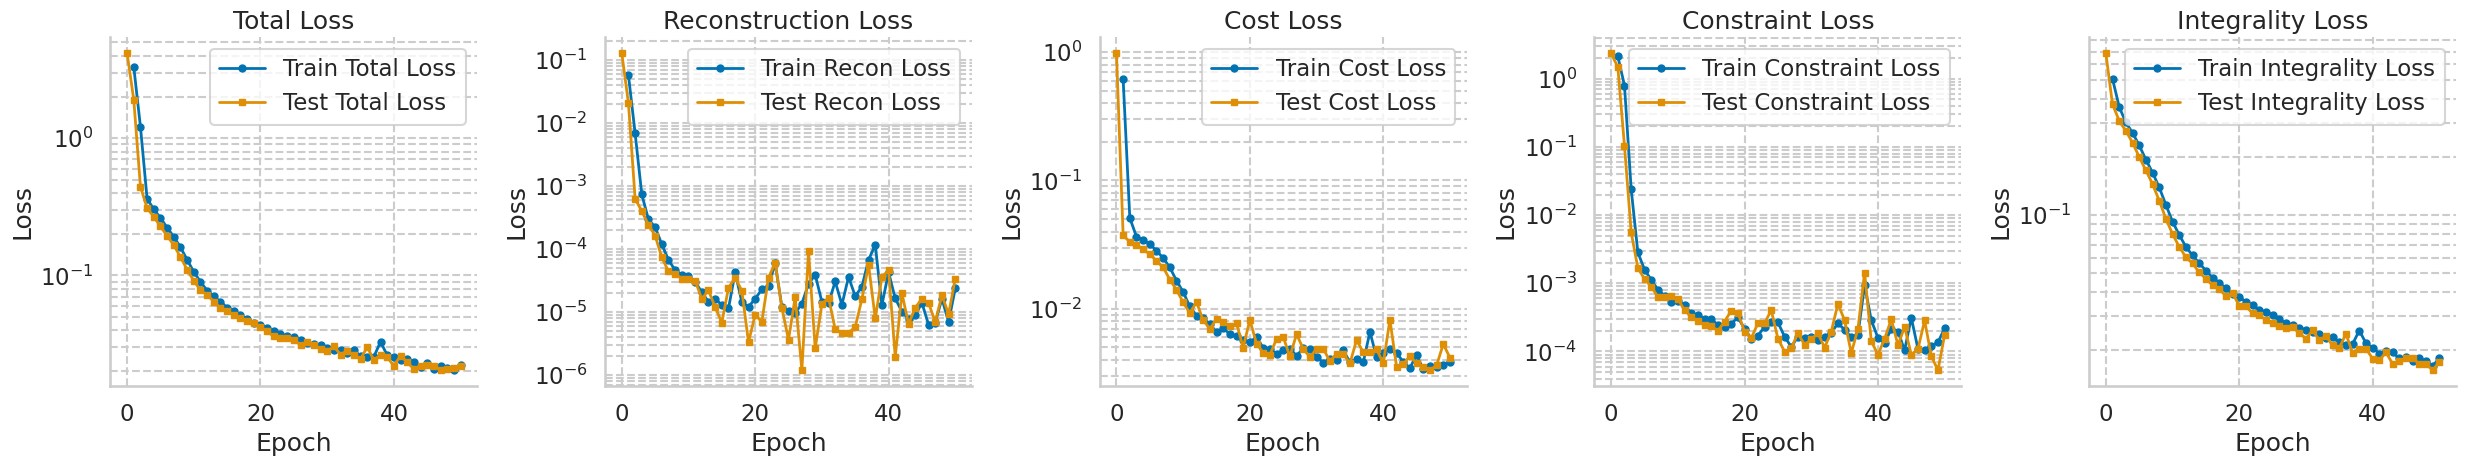

In [22]:
from plotting import plot_losses
import seaborn as sns

plot_losses(
    num_epochs,
     train_total_losses, train_recon_losses, train_cost_losses, train_constraint_losses, train_integrality_losses,
     test_total_losses, test_recon_losses, test_cost_losses, test_constraint_losses, test_integrality_losses
)

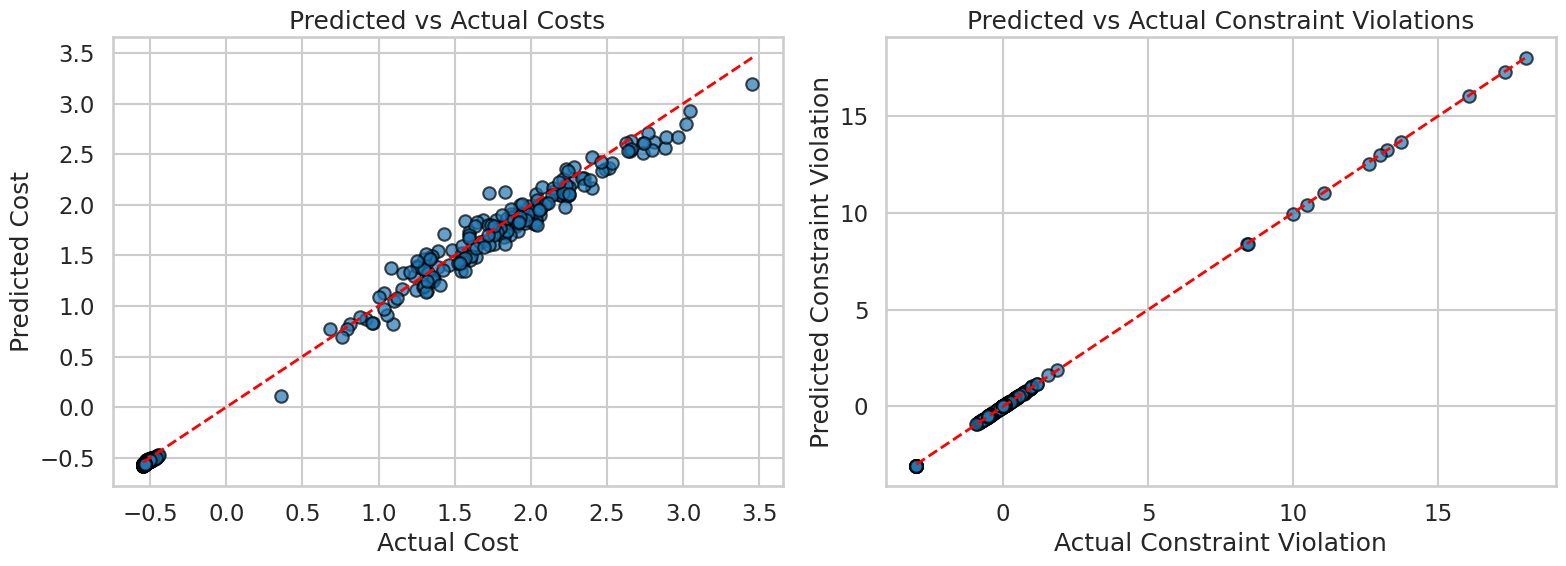

In [11]:
from plotting import plot_predictions_vs_actuals

model.eval()


plot_predictions_vs_actuals(model, test_loader, device=device, num_samples_to_show=1000)

In [27]:
train_loader, test_loader, (mean_obj, std_obj, mean_feas, std_feas, mean_y_x, std_y_x, mean_y_cost, std_y_cost, mean_y_constraints, std_y_constraints) = prepare_data(
    Q, A, E, n_variables,
    infeasible_solutions, infeasible_costs,
    infeasible_solutions, infeasible_costs,
    infeasible_nonintegral_solutions, infeasible_nonintegral_costs,
    variable_types_tensor, variable_lower_bounds, variable_upper_bounds,
    b_vector, d_vector,
    batch_size=1, device=device
)

data_obj_batch, data_feas_batch = next(iter(test_loader))

In [37]:
def hat_c_theta(z_opt, model, batch):
    """
    Compute the predicted cost from the latent embedding z_opt.
    z_opt: [num_variables, hidden_channels_obj+hidden_channels_cons]
    batch: [num_variables] assigning each variable node to a graph component.
    model: trained JointGNN model.
    """
    # The model uses global_mean_pool on z_opt to predict cost:
    x_var_pooled = global_mean_pool(z_opt, batch)
    predicted_cost = model.decoder_cost(x_var_pooled).squeeze()
    return predicted_cost

def hat_g_theta(z_feas, model):
    """
    Compute the predicted constraint violations from the latent embedding z_feas.
    z_feas: [num_constraints, hidden_channels_cons]
    model: trained JointGNN model.
    """
    predicted_constraints = model.decoder_constraints(z_feas).squeeze()
    return predicted_constraints

def Dec(z_opt, model):
    """
    Decode from z_opt back to x.
    z_opt: [num_variables, hidden_channels_obj+hidden_channels_cons]
    Uses model.decoder_x to get x_hat.
    """
    x_hat = model.decoder_x(z_opt).squeeze()
    return x_hat

# =======================
# Example of Latent Optimization After Training
# =======================

# Let's pick one batch from test_loader to demonstrate latent optimization
data_obj_batch, data_feas_batch = next(iter(test_loader))
model.eval()  # Ensure model is in eval mode

with torch.no_grad():
    # Forward pass to get embeddings:
    data_obj_batch = data_obj_batch.to(device)
    data_feas_batch = data_feas_batch.to(device)
    x_obj = model.encoder_obj(data_obj_batch)
    x_cons_var, x_cons_constraints = model.encoder_cons(data_feas_batch)

    # z_opt = x_var = concat(x_obj_var, x_cons_var)
    x_obj_var = x_obj[data_obj_batch.variable_mask]
    z_opt_init = torch.cat([x_obj_var, x_cons_var], dim=1)

    # z_feas = x_cons_constraints
    z_feas_init = x_cons_constraints

# Now we have initial embeddings z_opt_init and z_feas_init from the model's encoders.
# We'll treat these as starting points. In practice, you could also start from random embeddings:
# z_opt_init = torch.randn_like(z_opt_init)
# z_feas_init = torch.randn_like(z_feas_init)

z_opt = z_opt_init.clone().detach().requires_grad_(True)
z_feas = z_feas_init.clone().detach().requires_grad_(True)

alpha_opt = 0.01
alpha_feas = 0.01
mu = 10.0
num_iterations = 200

# We need the 'batch' vector for variables to compute cost pooling:
batch_var = data_obj_batch.batch[data_obj_batch.variable_mask]

opt_optimizer = torch.optim.SGD([z_opt], lr=alpha_opt)
feas_optimizer = torch.optim.SGD([z_feas], lr=alpha_feas)

print(data_obj_batch.y_x)

for t in range(num_iterations):
    # Update z_feas:
    feas_optimizer.zero_grad()
    cost_val = hat_c_theta(z_opt, model, batch_var)
    constraints_val = hat_g_theta(z_feas, model)
    violation = constraints_val
    feas_loss = cost_val + mu * (violation.pow(2).sum())
    feas_loss.backward(retain_graph=True)
    feas_optimizer.step()

    print(constraints_val)

    # Update z_opt:
    opt_optimizer.zero_grad()
    cost_val = hat_c_theta(z_opt, model, batch_var)  # recompute after z_feas update
    cost_val.backward()
    opt_optimizer.step()

# After optimization, decode:
    x_star = Dec(z_opt.detach(), model)
    x_star = x_star.detach().cpu().numpy()

    Ex = E @ x_star

    print(Ex)
    
    

# x_star now is the solution predicted from the optimized latent embeddings.
# You can now inspect x_star, run it through a solver, or use as a candidate solution.

print("Optimized solution x_star:", x_star)
print("Predicted Cost at x_star:", hat_c_theta(z_opt.detach(), model, batch_var).item())
print("Predicted Constraints at x_star:", hat_g_theta(z_feas.detach(), model).detach().cpu().numpy())



Iteration: 0 Equality constraint residual: [2.13346457]
Predicted Constraints: 0.7728292346000671
Iteration: 1 Equality constraint residual: [15830.52783203]
Predicted Constraints: 11765.365234375
Iteration: 2 Equality constraint residual: [16250.46789551]
Predicted Constraints: 11765.365234375
Iteration: 3 Equality constraint residual: [16258.21850586]
Predicted Constraints: 11765.365234375
Iteration: 4 Equality constraint residual: [16258.37512207]
Predicted Constraints: 11765.365234375
Iteration: 5 Equality constraint residual: [16258.37854004]
Predicted Constraints: 11765.3662109375
Iteration: 6 Equality constraint residual: [16258.37866211]
Predicted Constraints: 11765.3662109375
Iteration: 7 Equality constraint residual: [16258.37854004]
Predicted Constraints: 11765.3662109375
Iteration: 8 Equality constraint residual: [16258.37854004]
Predicted Constraints: 11765.365234375
Iteration: 9 Equality constraint residual: [16258.37860107]
Predicted Constraints: 11765.365234375
Iteratio

In [30]:
data_feas_batch.y_x

tensor([0.0482, 0.0000, 0.2333, 0.0000, 0.0511, 0.6971, 0.0000, 0.0000, 0.0559,
        0.0000, 0.0000, 0.0016, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0567,
        0.1527, 0.0000, 0.0280, 0.0810, 0.2131, 0.0396, 0.5186, 0.0000, 0.0107,
        0.0000, 0.0000, 0.1755, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, 1.0000,
        0.0000, -0.0000, -0.0000, -0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -0.0000,
        -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, 0.0000, -0.0000, 0.0000, 0.0000,
        1.0000, -0.0000, -0.0000, 0.0000, -0.0000, 0.0000], device='cuda:0')

In [31]:
x_star

tensor([6.3634e+02, 6.3626e+02, 6.3665e+02, 6.3625e+02, 6.3632e+02, 6.3738e+02,
        6.3623e+02, 6.3624e+02, 6.3636e+02, 6.3623e+02, 6.3624e+02, 6.3625e+02,
        6.3625e+02, 6.3625e+02, 6.3626e+02, 6.3624e+02, 6.3624e+02, 6.5800e+02,
        6.7000e+02, 6.7136e+02, 6.5783e+02, 6.5850e+02, 6.5811e+02, 6.5779e+02,
        6.5989e+02, 6.6306e+02, 6.5824e+02, 6.5849e+02, 6.5839e+02, 6.5875e+02,
        8.0686e-03, 8.0686e-03, 8.0686e-03, 8.0686e-03, 8.0686e-03, 1.0066e+00,
        8.0686e-03, 8.0686e-03, 8.0686e-03, 8.0686e-03, 8.0686e-03, 8.0686e-03,
        8.0686e-03, 8.0686e-03, 8.0686e-03, 8.0686e-03, 8.0686e-03, 8.0686e-03,
        8.0686e-03, 8.0686e-03, 8.0686e-03, 8.0686e-03, 8.0686e-03, 8.0686e-03,
        1.0066e+00, 8.0686e-03, 8.0686e-03, 8.0686e-03, 8.0686e-03, 8.0686e-03],
       device='cuda:0', grad_fn=<SqueezeBackward0>)

In [33]:
# Suppose x_star is obtained from Dec(z_opt, model)
# Ensure x_star is on CPU for simplicity:
x_star = x_star.detach().cpu().numpy()

tolerance = 1e-6

# Check inequalities: A x_star <= b
Ax = A @ x_star
feasible_ineq = np.all(Ax <= b_vector + tolerance)

# Check equalities: E x_star = d
Ex = E @ x_star
feasible_eq = np.all(np.abs(Ex - d_vector) <= tolerance)

if feasible_ineq and feasible_eq:
    print("Solution is feasible.")
else:
    print("Solution is not feasible.")
    if not feasible_ineq:
        violated_amount = (Ax - b_vector)[Ax > b_vector + tolerance]
        print("Inequality constraints violated. Violations:", violated_amount)
    if not feasible_eq:
        eq_violations = (Ex - d_vector)[np.abs(Ex - d_vector) > tolerance]
        print("Equality constraints violated. Violations:", eq_violations)


Solution is not feasible.
Inequality constraints violated. Violations: [636.32963887 636.24815694 636.64317647 636.24046651 636.31108418
 636.37412941 636.22618428 636.23338643 636.35557881 636.22606221
 636.23668233 636.2458376  636.2435793  636.24608174 636.25499288
 636.22874776 636.22911397 657.99638692 669.99071065 671.34959737
 657.81743184 658.4946169  658.10612813 657.77714864 658.88102639
 663.05577413 658.2322878  658.47813741 658.38634053 658.74156514]
Equality constraints violated. Violations: [19405.41918945]


In [17]:
np.round(x_star[:30], 3)

array([0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015,
       0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.016,
       0.017, 0.017, 0.016, 0.016, 0.016, 0.016, 0.541, 0.016, 0.494,
       0.016, 0.016, 0.016], dtype=float32)

In [18]:
np.round(x_star[30:], 3)

array([0.008, 0.008, 0.008, 0.008, 0.008, 0.008, 0.008, 0.008, 0.008,
       0.008, 0.008, 0.008, 0.008, 0.008, 0.008, 0.008, 0.008, 0.008,
       0.008, 0.008, 0.008, 0.008, 0.008, 0.008, 1.006, 0.008, 1.006,
       0.008, 0.008, 0.008], dtype=float32)

In [19]:
x_hat, predicted_cost, predicted_constraints, predicted_integrality = model(data_obj_batch, data_feas_batch)

In [20]:
x_hat

tensor([0.0089, 0.0089, 0.0089, 0.0089, 0.0089, 0.0089, 0.0089, 0.0089, 0.0089,
        0.0089, 0.0089, 0.0089, 0.0089, 0.0089, 0.0089, 0.0089, 0.0089, 0.0092,
        0.0100, 0.0101, 0.0092, 0.0092, 0.0092, 0.0091, 0.5342, 0.0095, 0.4864,
        0.0092, 0.0092, 0.0092, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027,
        0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027,
        0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027,
        0.9994, 0.0027, 0.9994, 0.0027, 0.0027, 0.0027], device='cuda:0',
       grad_fn=<SqueezeBackward0>)

In [21]:
data_obj_batch.y_x

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5234, 0.0000, 0.4766,
        0.0000, 0.0000, 0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
        -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
        -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
        1.0000, -0.0000, 1.0000, -0.0000, -0.0000, -0.0000], device='cuda:0')